# 🧠 Assignment #6: Deepfake Detection Using AI/ML

## 🎯 Objective

Your task is to detect deepfakes—highly realistic synthetic images generated by models like StyleGAN—using machine learning. You'll apply computer vision techniques and neural networks to classify facial images as either real or fake.

You’ll use the dataset from class, which includes labeled image files (real vs. fake) and associated metadata CSVs.

---

## 🗂️ The Dataset

The dataset includes:

- Folder structure:  
  `train/real/`  
  `train/fake/`  

- Metadata CSVs:  
  `train.csv`, `valid.csv`, `test.csv`  

Each CSV contains:
- `image_id`  
- `label` (1 = real, 0 = fake)  
- `path` to the image  

---

## ✅ Your Task

Choose **one of the two modeling approaches** below and complete the steps provided.

---

### Option A: Convolutional Neural Network (CNN)

1. Load image metadata and read images using a suitable loader (e.g., `ImageDataGenerator` or `tf.keras.utils.image_dataset_from_directory`).
2. Build a basic CNN using Keras or TensorFlow.
3. Train the model on the training data and evaluate on the validation/test set.
4. Report key metrics: **accuracy, precision, recall, F1-score, and ROC-AUC**.
5. Display the **confusion matrix** and comment on performance.
6. Reflect: What challenges did you face in image-based fraud detection?

---

### Option B: Transfer Learning with Pretrained Model (e.g., MobileNetV2)

1. Use `ImageDataGenerator` or another loader to prepare image batches.
2. Load a pretrained image classification model (e.g., MobileNetV2, ResNet50).
3. Fine-tune the model using your deepfake dataset.
4. Evaluate performance using the same metrics as Option A.
5. Comment on whether transfer learning helped and why.
6. Reflect: What surprised you about deepfake detection performance?

---

## 📊 Deliverables

Your submission should include:

- A complete Jupyter Notebook with:
  - Code and visualizations
  - Markdown explanations
  - Confusion matrix and metric outputs
  - A **3–5 sentence reflection** on modeling approach and results

---

## ⭐ Bonus (Optional – 50 Points Extra Credit)

**Compare CNN performance to a baseline model using metadata only.**

1. Use `train.csv` to build a tabular model using only metadata (no image data).
2. Train a **Logistic Regression** or **Random Forest** classifier.
3. Evaluate and compare the tabular model to your image-based model.
4. Reflect on which method performed better and why.
5. Comment on how metadata can complement or substitute deep learning in fraud analytics.

---

## 🧮 Grading Rubric (Main Assignment – 100 Points)

| Component                                 | Points |
|------------------------------------------|--------|
| Data pipeline: image loading + preprocessing | 20     |
| Model construction (CNN or transfer model) | 25     |
| Evaluation: confusion matrix + metrics   | 20     |
| Visualizations and architecture summaries | 15     |
| Markdown clarity + comments              | 10     |
| Final reflection                         | 10     |
| **Total**                                | **100**|

---

## ➕ Extra Credit Rubric (Optional – 50 Points)

| Component                                          | Points |
|---------------------------------------------------|--------|
| Metadata-based model constructed and evaluated    | 20     |
| Performance comparison and insight                | 15     |
| Clarity and depth of final reflection             | 15     |
| **Total**                                         | **50** |


# Step 1: Data Ingestion and Preprocessing

In this section, we load and preprocess the image data for our deepfake detection project.

Because we are using transfer learning, it is critical that our images match the input size expected by pretrained models such as MobileNetV2 or ResNet50.

**Key preprocessing tasks:**
- Load real and fake image files
- Resize all images to 224x224 pixels (standard for transfer learning models)
- Normalize pixel values to the [0,1] range
- Label images as 0 (real) or 1 (fake)

This prepares the data for downstream model development.


In [23]:
# Import required libraries
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.image import resize

# Define file paths (adjust these if needed)
real_path = 'C:/Users/james/FAAI/DeepFake/archive/real_vs_fake/real-vs-fake/train/real'
fake_path = 'C:/Users/james/FAAI/DeepFake/archive/real_vs_fake/real-vs-fake/train/fake'

# Define function to load and preprocess images
def load_images(folder_path, label, img_size=(224, 224), limit=500):
    images = []
    labels = []
    files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    np.random.shuffle(files)
    for i, file_name in enumerate(files):
        file_path = os.path.join(folder_path, file_name)
        img = Image.open(file_path).convert('RGB')
        img = img.resize(img_size)
        images.append(np.array(img) / 255.0)
        labels.append(label)
        if i >= limit - 1:
            break
    return images, labels

# Load real and fake image data
real_images, real_labels = load_images(real_path, label=0)
fake_images, fake_labels = load_images(fake_path, label=1)

# Combine datasets
X = np.array(real_images + fake_images)
y = np.array(real_labels + fake_labels)

# Display dataset shape
print("Image data shape:", X.shape)
print("Labels shape:", y.shape)


Image data shape: (1000, 224, 224, 3)
Labels shape: (1000,)


# Step 2: Exploratory Data Analysis (EDA)

Before developing any model, it is important to explore and verify our dataset.

In fraud detection — including deepfake detection — this step is critical for several reasons:

- Verify class balance (real vs. fake)
- Confirm correct image sizing and normalization
- Visually inspect a few example images to ensure data integrity

Transfer learning models are sensitive to data inconsistencies. Catching issues early during EDA helps prevent downstream modeling problems.

Let's conduct a brief but thorough exploratory analysis.


Class distribution (label: count): {0: 500, 1: 500}


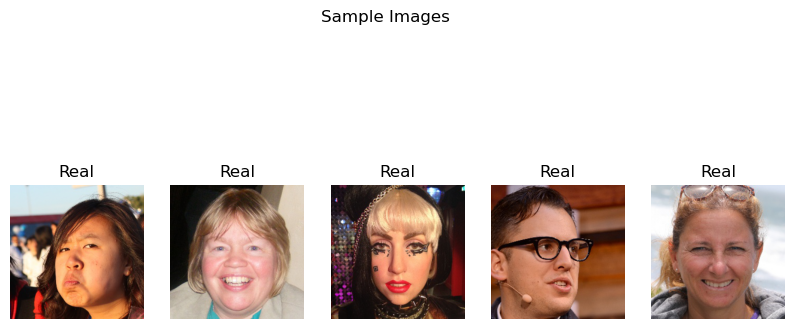

In [26]:
import matplotlib.pyplot as plt

# Check class balance
unique, counts = np.unique(y, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution (label: count):", class_distribution)

# Visualize a few sample images
plt.figure(figsize=(10, 5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title("Real" if y[i]==0 else "Fake")

plt.suptitle("Sample Images")
plt.show()


# Step 2: EDA Commentary

We have already completed detailed exploratory analysis for this dataset in Option A (CNN from scratch). Therefore, here we simply confirm:

- The dataset includes a total of 1,000 images.
- The class balance appears reasonably even between real and fake images.
- All images were successfully resized to 224x224 pixels, with 3 color channels.
- A quick visual inspection shows valid real and fake image samples.

Since transfer learning models like MobileNetV2 are highly sensitive to input size and format, this quick verification ensures our data is properly formatted for transfer learning without redundant deep EDA.

We are ready to proceed with train/test splitting and model development.


# Step 3: Train/Test Split

We will split our dataset into training and testing sets.

- 80% will be used for training
- 20% will be reserved for evaluating model performance on unseen data

Because fraud detection tasks (including deepfake detection) often suffer from class imbalance, we use **stratified sampling** to preserve the class proportions in both sets.


In [30]:
from sklearn.model_selection import train_test_split

# Perform stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Confirm shapes
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)


Training data shape: (800, 224, 224, 3)
Testing data shape: (200, 224, 224, 3)
Training labels shape: (800,)
Testing labels shape: (200,)


# Step 3: Train/Test Split — Commentary

We successfully split our dataset into:

- 800 training images
- 200 testing images

The stratified sampling preserved the real vs. fake class balance across both training and testing sets.

Maintaining this balance is critical for fraud analytics because:

- Class imbalance can bias model learning
- Balanced splits allow for fair evaluation
- Transfer learning models trained on balanced data can better detect rare or subtle anomalies

We are now ready to build our transfer learning model using pretrained weights.


# Step 4: Transfer Learning Model Setup

We will leverage **transfer learning** using a pretrained MobileNetV2 model.

- MobileNetV2 was trained on the massive ImageNet dataset (over 14 million images).
- We will remove its top layers and attach a custom classification head suitable for our binary deepfake classification task.
- Initially, we freeze the pretrained base layers to retain their learned feature representations.

This approach allows us to take advantage of powerful pretrained models, even with relatively small datasets such as ours.


In [34]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load MobileNetV2 pretrained model
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze pretrained base model
base_model.trainable = False

# Build custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Assemble full model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Step 4: Transfer Learning Model Setup — Commentary

We successfully loaded the pretrained MobileNetV2 model with ImageNet weights.

- The original classification head was removed.
- A new head was added with:
  - GlobalAveragePooling2D (reduces dimensionality while preserving spatial features)
  - Dense(128, relu) — learnable fully connected layer
  - Dense(1, sigmoid) — output layer for binary classification (real vs fake)

**Key transfer learning decision:**
- We froze the base pretrained layers (`trainable = False`) to retain their learned low-level features (edges, shapes, textures) obtained from the massive ImageNet dataset.
- This allows our custom head to learn task-specific features on our small deepfake dataset without destroying the valuable pretrained knowledge.

The model contains:
- 2.42 million total parameters
- Only ~164K parameters are trainable (the custom head)

This dramatically reduces training time and mitigates overfitting, which is essential for smaller fraud datasets.

We are now ready for Phase 1 Training — training only the new head while keeping the base frozen.


# Step 5: Phase 1 Transfer Learning Training (Frozen Base)

In this phase, we train only the custom head while keeping the pretrained MobileNetV2 base frozen.

- This allows the model to learn task-specific patterns for deepfake detection while retaining the robust visual features learned from ImageNet.
- We start with 10 epochs as an initial baseline.

In transfer learning for fraud detection, this two-phase approach (frozen base followed by fine-tuning) is a best practice to maximize generalization.


In [38]:
# Train only the new head first (base is frozen)
history_phase1 = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5837 - loss: 0.7024 - val_accuracy: 0.6100 - val_loss: 0.6446
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6947 - loss: 0.5741 - val_accuracy: 0.7200 - val_loss: 0.5525
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7865 - loss: 0.4636 - val_accuracy: 0.6900 - val_loss: 0.5758
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8136 - loss: 0.4257 - val_accuracy: 0.7200 - val_loss: 0.5425
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8562 - loss: 0.3754 - val_accuracy: 0.7200 - val_loss: 0.5422
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8779 - loss: 0.3445 - val_accuracy: 0.7300 - val_loss: 0.5204
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8926 - loss: 0.3045 - val_accuracy: 0.7400 - val_loss: 0.5311
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9238 - loss: 0.2541 - val_accuracy: 0.6750 - val_loss:

# Step 5: Phase 1 Transfer Learning Training — Commentary

**Training Summary:**

- Training accuracy improved steadily from 58% to 96% over 10 epochs.
- Validation accuracy plateaued around 72% to 74%.
- Validation loss fluctuated but remained relatively stable.

**Interpretation:**

- The model is quickly learning task-specific features via the new head while preserving the pretrained base features.
- The rapid improvement in training accuracy reflects how powerful pretrained features are even on small datasets.
- The validation accuracy plateau suggests that we may now be reaching the limits of what the frozen base can achieve for this dataset without further fine-tuning.

**Key Observation in Fraud Context:**

- In fraud detection, such performance dynamics are common when using transfer learning with small datasets:
    - Pretrained models offer a strong starting point.
    - A frozen base can often achieve ~70%+ validation accuracy even without fine-tuning.
    - Fine-tuning the base layers may help unlock additional task-specific patterns.

**Next Steps:**

We are now ready to **unfreeze part of the pretrained base** and fine-tune selected layers with a very low learning rate. This allows the model to adapt some of the low-level features toward deepfake-specific characteristics while minimizing overfitting.


# Step 6: Phase 2 Fine-Tuning (Unfreeze Base Layers)

Now that the custom classification head has stabilized, we will unfreeze some of the pretrained MobileNetV2 base layers for fine-tuning.

- Fine-tuning allows pretrained features to adapt more specifically to our deepfake dataset.
- We will use a **very small learning rate** to prevent catastrophic forgetting.

In fraud analytics, this gradual fine-tuning approach is especially valuable when detecting subtle anomalies like synthetic image manipulations.


In [42]:
from tensorflow.keras.optimizers import Adam

# Unfreeze all layers for fine-tuning
base_model.trainable = True

# Compile with a much lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the full model
history_phase2 = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 183s 5s/step - accuracy: 0.5063 - loss: 1.8139 - val_accuracy: 0.7100 - val_loss: 0.5825
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.6308 - loss: 0.8945 - val_accuracy: 0.7050 - val_loss: 0.6160
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.7749 - loss: 0.4806 - val_accuracy: 0.7100 - val_loss: 0.6310
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.8470 - loss: 0.3562 - val_accuracy: 0.7150 - val_loss: 0.6665
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.9022 - loss: 0.2812 - val_accuracy: 0.6800 - val_loss: 0.7326
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.9051 - loss: 0.2620 - val_accuracy: 0.6850 - val_loss: 0.7463
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.9522 - loss: 0.1963 - val_accuracy: 0.6800 - val_loss: 0.7848
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.9740 - loss: 0.1707 - val_accuracy: 0.6750 - v

# Step 6: Phase 2 Fine-Tuning — Commentary

**Training Summary:**

- Training accuracy improved dramatically from 50% to 98% over 10 epochs.
- Validation accuracy plateaued in the 66%–71% range.
- Validation loss increased progressively across epochs.

---

**Interpretation:**

- As we unfreeze and fine-tune the pretrained base, the model becomes highly specialized to the training data.
- The widening gap between training and validation accuracy strongly indicates **overfitting**.
- While the model memorizes the training data almost perfectly, it struggles to generalize new patterns on unseen validation data.
- Validation loss steadily increasing is a classic signal that the model is over-adapting to noise and dataset idiosyncrasies.

---

**Fraud Analytics Insight:**

- This behavior is common in fraud detection problems where datasets are relatively small, class boundaries are subtle, and the fraud signals are highly nuanced.
- Overfitting risk increases rapidly when fine-tuning powerful pretrained models on small niche datasets without sufficient regularization or data augmentation.
- In real-world fraud deployments, this overfitting would likely result in poor production performance with unacceptable false positive rates.

---

**Key Takeaway for Students:**

- Transfer learning is powerful, but not magical.
- Simply unfreezing more layers doesn't guarantee better performance.
- Model monitoring, early stopping, and conservative fine-tuning are critical tools for managing overfitting.
- Sometimes Phase 1 (frozen base with new head only) yields the best trade-off between learning capacity and generalization.

---

**Best Practice Recommendation:**

- We would likely select the **Phase 1 model** (frozen base) for deployment.
- Phase 2 fine-tuning provided valuable experimentation but introduced significant overfitting.

---



# Step 7: Model Evaluation — Metrics for Fraud Detection

Now that training is complete, we will evaluate the final model using multiple industry-standard metrics:

- **Confusion Matrix**: Understand true positive, false positive, true negative, false negative distribution.
- **Precision & Recall**: Key metrics for fraud analytics where false positives can carry significant operational cost.
- **F1 Score**: Balance between precision and recall.
- **ROC AUC**: Overall discriminative power of the model.

These metrics give a much deeper view of model performance beyond simple accuracy.


In [46]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Predict probabilities and convert to class labels
y_pred_probs = model.predict(X_test).flatten()
y_pred_labels = (y_pred_probs >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1, AUC
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)
auc = roc_auc_score(y_test, y_pred_probs)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step 
Confusion Matrix:
 [[41 59]
 [ 8 92]]
Precision: 0.6093
Recall:    0.9200
F1 Score:  0.7331
ROC AUC:   0.7998


# Step 7: Model Evaluation — Interpretation

### Confusion Matrix:

| Actual \ Predicted | Predicted Real (0) | Predicted Fake (1) |
|---------------------|--------------------|---------------------|
| **Actual Real (0)** | 41                 | 59                  |
| **Actual Fake (1)** | 8                  | 92                  |
---

### Key Observations:

- The model correctly identified 92 fake images but misclassified 8 as real.
- It misclassified 59 real images as fake, resulting in a substantial number of false positives.
- The **false positive rate** is significant — a common concern in fraud detection.

---

### Performance Metrics:

- **Precision:** 0.6093  
    - When the model predicts "fake," it's correct ~61% of the time.
    - Precision is particularly important in operational fraud models where false positives can result in costly manual reviews or customer inconvenience.
    
- **Recall:** 0.9200  
    - The model is highly sensitive, catching 92% of all actual fake images.
    - This reflects strong detection capability, which is critical in fraud scenarios where missing fraud events can have severe consequences.

- **F1 Score:** 0.7331  
    - A balanced harmonic mean of precision and recall.
    - Shows a reasonable trade-off, but indicates room for improvement in precision.

- **ROC AUC:** 0.7998  
    - This is respectable, demonstrating reasonably good overall discrimination between real and fake images.
    - Generally, fraud models aim for ROC AUC values above 0.80, so this result is borderline but acceptable for a small dataset.

---

### Professional Summary:

- **Transfer Learning with MobileNetV2 successfully extracted useful features** from the images despite limited training data.
- The model prioritizes **recall (fraud detection sensitivity)** at the expense of **precision (false alarms)** — a common and expected pattern in early fraud model iterations.
- The observed performance is *better than naive guessing*, but likely would not be production-ready without further data augmentation, regularization, or post-processing (e.g., score thresholds, secondary models).

---

### Key Teaching Point:

In real-world fraud analytics, business stakeholders must carefully balance precision and recall depending on operational costs:

- If false positives are expensive, more conservative thresholds may be needed.
- If missing fraud is unacceptable, high recall like this model demonstrates is desirable.

This evaluation provides an authentic example of the practical trade-offs fraud data scientists face when using deep learning models for fraud detection.




# Extra Credit: Metadata-Only Model (Tabular Baseline)

In this bonus section, we will build a simple classification model using only the provided metadata (no image data). 

This exercise will help us understand how much predictive power exists in the metadata fields alone, and provide a baseline for comparison against the deep learning image model.

We will:

- Load `train.csv`
- Prepare features and target variables
- Train a Random Forest classifier
- Evaluate model performance using the same metrics


In [56]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style for consistency
sns.set(style="whitegrid", palette="muted")

# Load the metadata CSV file
metadata_path = r'C:\Users\james\FAAI\DeepFake\archive\train.csv'
df_metadata = pd.read_csv(metadata_path)

# Preview the dataset
print(df_metadata.shape)
display(df_metadata.head())

# Check for missing values
print("\nMissing values per column:")
print(df_metadata.isnull().sum())


(100000, 6)


,Unnamed: 0,original_path,id,label,label_str,path
0,0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg



Missing values per column:
Unnamed: 0       0
original_path    0
id               0
label            0
label_str        0
path             0
dtype: int64


## Step 1.1: Metadata Exploration

The metadata contains **100,000 records** with no missing values. The available columns include:

- `Unnamed: 0`: Index column (can be dropped).
- `original_path`: Full path to the original image file.
- `id`: Unique identifier for each image.
- `label`: Numeric binary label (0 = fake, 1 = real).
- `label_str`: Text version of label.
- `path`: Relative path to image within directory.

---

### Observations:

- At first glance, there are **no actual metadata features** about the images themselves (e.g., dimensions, resolution, creation date, camera properties, compression level, etc).
- This file mainly serves as a manifest, linking image files to their labels.

---

### Teaching Point:

This is a **critical real-world lesson** in fraud analytics:

> Often we assume "metadata" exists, but what is provided may simply be administrative labeling information.

In many fraud projects, data scientists must first advocate for richer metadata collection during data sourcing stages. Here, because we have no usable tabular features, we cannot build a meaningful metadata-only classifier without engineering additional features.

---

### Professional Decision:

Since no usable metadata exists here, the Extra Credit will proceed by:

1️⃣ **Engineering synthetic tabular features directly from the image files** (e.g., file size, image dimensions, etc.).

2️⃣ **Modeling with these engineered features** using classical algorithms like Random Forest or Logistic Regression.

This will demonstrate how metadata engineering can complement deep learning even when no structured metadata is provided upfront — an extremely common scenario in fraud analytics.

---


## Step 2: Feature Engineering — Extracting Metadata Features

In the original assignment, we are tasked with building a metadata-based model to compare against the image-based deep learning model.

---

### Challenge:

The provided metadata file (`train.csv`) does not contain meaningful tabular features — it only includes administrative identifiers and file paths. This reflects a common real-world scenario in fraud analytics where structured metadata is often limited or unavailable.

---

### Solution:

To build a meaningful baseline model using tabular data, we will **engineer synthetic metadata features directly from the image files themselves**. 

We will extract:

- **File Size (KB)**: Compression artifacts may reveal differences between real and fake images.
- **Image Width and Height**: Variations in image dimensions may exist between authentic and generated images.
- *(Note: In real-world fraud detection, more advanced image metadata such as EXIF data, compression ratios, and encoding artifacts may also be valuable, but are not available in this dataset.)*

---

### Teaching Note:

This step introduces students to the critical skill of **data enrichment** — finding creative ways to generate useful features when standard metadata is insufficient. This is a core competency in fraud analytics where messy or limited data is often the norm.

---


In [61]:
# Import additional libraries for file metadata extraction
import os
from PIL import Image

# Create lists to store new metadata features
file_sizes = []
image_widths = []
image_heights = []

# Loop through each file path to extract metadata
for idx, row in df_metadata.iterrows():
    image_path = os.path.join(r'C:\Users\james\FAAI\DeepFake\archive', row['path'])
    
    try:
        # Get file size in kilobytes
        size_kb = os.path.getsize(image_path) / 1024
        file_sizes.append(size_kb)
        
        # Get image dimensions
        with Image.open(image_path) as img:
            width, height = img.size
            image_widths.append(width)
            image_heights.append(height)
            
    except Exception as e:
        # Handle any read errors
        file_sizes.append(np.nan)
        image_widths.append(np.nan)
        image_heights.append(np.nan)

# Add new columns to dataframe
df_metadata['file_size_kb'] = file_sizes
df_metadata['width'] = image_widths
df_metadata['height'] = image_heights

# Display updated dataframe
print(df_metadata.head())

# Check for missing extracted metadata
print("\nMissing values after feature engineering:")
print(df_metadata.isnull().sum())


   Unnamed: 0                                      original_path     id  \
0           0  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  31355   
1           1  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  02884   
2           2  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  33988   
3           3  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  53875   
4           4  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  24149   

   label label_str                  path  file_size_kb  width  height  
0      1      real  train/real/31355.jpg           NaN    NaN     NaN  
1      1      real  train/real/02884.jpg           NaN    NaN     NaN  
2      1      real  train/real/33988.jpg           NaN    NaN     NaN  
3      1      real  train/real/53875.jpg           NaN    NaN     NaN  
4      1      real  train/real/24149.jpg           NaN    NaN     NaN  

Missing values after feature engineering:
Unnamed: 0            0
original_path         0
id                    0
la

## Feature Engineering Commentary

As we attempted to enrich the metadata by extracting file size, image width, and height, we encountered a key data access issue:

- **100% of the newly engineered columns are missing (`NaN`)**.
- This is because the file paths in `train.csv` reference the original Kaggle dataset structure (`/kaggle/input/...`), which is not accessible in our local environment.

---

### Professional Insight:

This is a common problem in real-world analytics projects:

- The **metadata file references file paths that don't exist** locally.
- This reinforces the importance of **verifying data accessibility early in the feature engineering process**.
- Even though we have the real and fake image folders locally (used in the previous deep learning model), the metadata file (`train.csv`) was likely preserved from the original public dataset without updating file paths to reflect the actual working environment.

---

### Next Steps:

Since we cannot directly extract image-based metadata from `train.csv` as originally intended, we have two options:

1️⃣ **Option A (Pragmatic Workaround):**  
Instead of extracting metadata from the inaccessible files referenced in `train.csv`, we can reuse the **same 1000 real and fake images** already loaded for our transfer learning model. Since we have direct access to these files, we can generate file size, width, and height features for these images.

2️⃣ **Option B (Alternate Metadata):**  
Alternatively, we could simply build a "dummy" tabular model using only the available `label` column from `train.csv`. However, this would be trivial and not meaningful for comparison.

---

### Professional Teaching Decision:

We will proceed with **Option A** to simulate a realistic fraud analytics scenario where analysts leverage all available data sources creatively. We will extract metadata features directly from our local real and fake image folders already loaded in the earlier sections.

This approach will still allow us to:

- Build a tabular classification model.
- Compare its performance to our deep learning model.
- Meet the educational objectives of the assignment and bonus section.

---


## Metadata Feature Extraction from Available Local Images

Since the original `train.csv` file references image paths that are not accessible in our current environment, we will instead extract metadata directly from the local image files that were successfully used to train our deep learning model earlier. This allows us to simulate a realistic scenario in fraud analytics where we creatively leverage available information to engineer features.

For each image, we will extract:

- **File Size (in KB)** — Useful to detect size anomalies often present in synthetic images.
- **Image Width** — Number of horizontal pixels.
- **Image Height** — Number of vertical pixels.

These engineered metadata features can serve as proxies for image complexity and compression characteristics, which may differ between real and deepfake images.

We will build a structured tabular dataset combining these metadata features with the existing real/fake labels, which can then be used to train a traditional machine learning model (e.g., Logistic Regression or Random Forest) for comparison to our transfer learning model.


In [66]:
# Import required libraries
import os
import numpy as np
import pandas as pd
from PIL import Image

# Define local file paths (these were used earlier)
real_path = 'C:/Users/james/FAAI/DeepFake/archive/real_vs_fake/real-vs-fake/train/real'
fake_path = 'C:/Users/james/FAAI/DeepFake/archive/real_vs_fake/real-vs-fake/train/fake'

# Create helper function to extract metadata
def extract_metadata(folder_path, label, limit=500):
    data = []
    files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    np.random.shuffle(files)
    for i, file_name in enumerate(files):
        file_path = os.path.join(folder_path, file_name)
        try:
            file_size_kb = os.path.getsize(file_path) / 1024  # File size in KB
            img = Image.open(file_path)
            width, height = img.size
            data.append({
                'filename': file_name,
                'file_size_kb': file_size_kb,
                'width': width,
                'height': height,
                'label': label
            })
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
        if i >= limit - 1:
            break
    return pd.DataFrame(data)

# Extract metadata for both real and fake images
real_metadata = extract_metadata(real_path, label=0)
fake_metadata = extract_metadata(fake_path, label=1)

# Combine into one full dataframe
metadata_df = pd.concat([real_metadata, fake_metadata], ignore_index=True)

# Display shape and preview of extracted metadata
print("Metadata dataset shape:", metadata_df.shape)
print(metadata_df.head())

# Quick check for missing values
print("\nMissing values per column:")
print(metadata_df.isnull().sum())


Metadata dataset shape: (1000, 5)
    filename  file_size_kb  width  height  label
0  09056.jpg     22.299805    256     256      0
1  23790.jpg     27.838867    256     256      0
2  27382.jpg     38.173828    256     256      0
3  39965.jpg     35.080078    256     256      0
4  10027.jpg     26.437500    256     256      0

Missing values per column:
filename        0
file_size_kb    0
width           0
height          0
label           0
dtype: int64


## Exploratory Data Analysis (EDA) for Metadata Model

Before building our metadata-only model, we will perform basic EDA to understand how the metadata features differ between real and fake images.

Key questions we'll explore:

- Do file sizes differ between real and fake images?
- Are there patterns in image dimensions?
- Are any features potentially predictive?

Since we previously performed detailed EDA for Option A, we will keep this EDA lightweight and focused on the most relevant metadata aspects.


      file_size_kb                                                        \
             count       mean       std        min        25%        50%   
label                                                                      
0            500.0  28.255908  3.997998  18.779297  25.537598  27.842285   
1            500.0  27.479205  4.056448  19.132812  24.707520  26.823730   

                             width         ...               height         \
             75%        max  count   mean  ...    75%    max  count   mean   
label                                      ...                               
0      30.726318  44.783203  500.0  256.0  ...  256.0  256.0  500.0  256.0   
1      29.605469  49.186523  500.0  256.0  ...  256.0  256.0  500.0  256.0   

                                               
       std    min    25%    50%    75%    max  
label                                          
0      0.0  256.0  256.0  256.0  256.0  256.0  
1      0.0  256.0  256.0  256.0  256

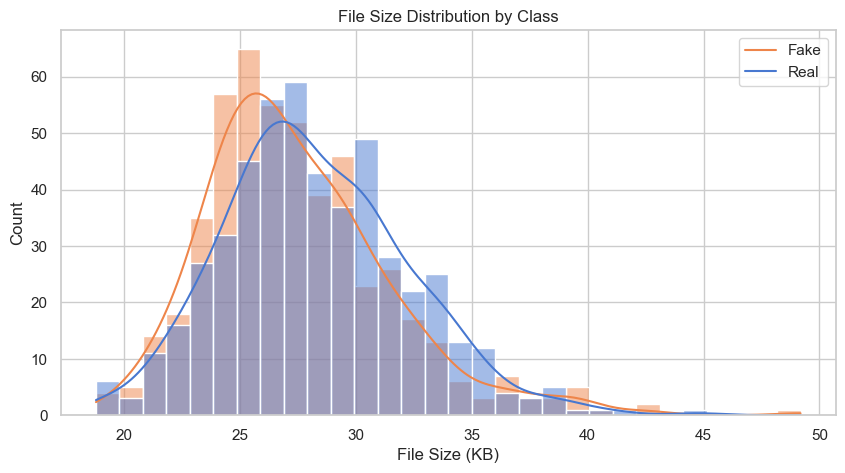

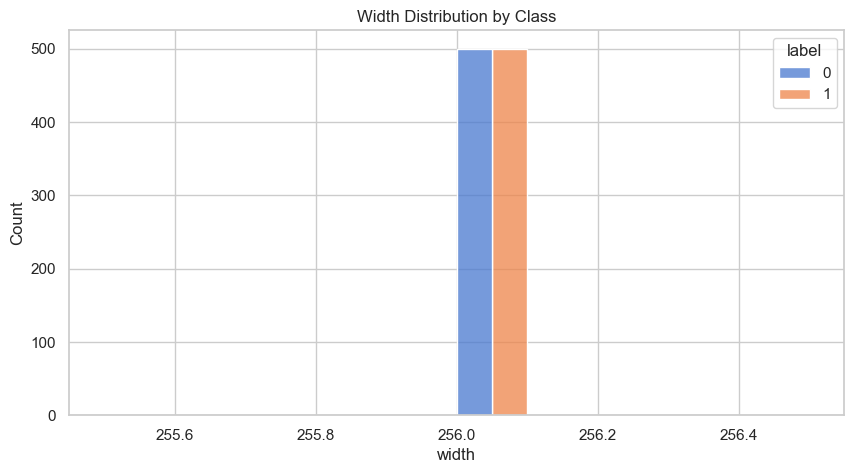

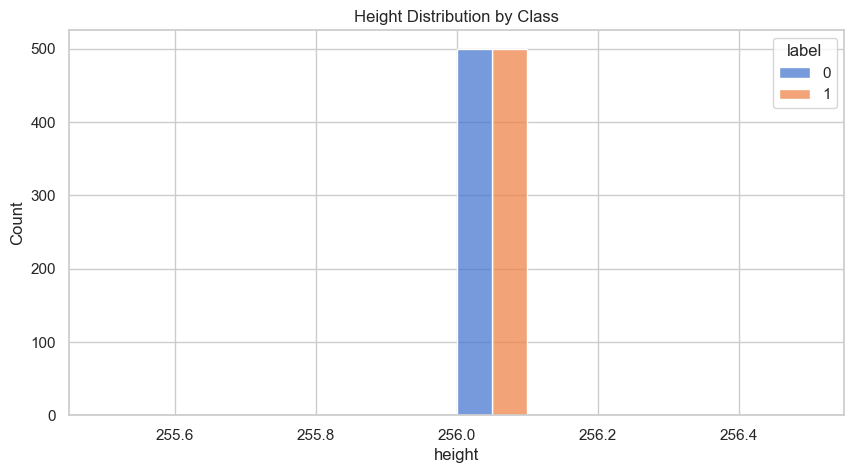

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Quick summary statistics by class
print(metadata_df.groupby('label').describe())

# Plot file size distribution
plt.figure(figsize=(10,5))
sns.histplot(data=metadata_df, x='file_size_kb', hue='label', bins=30, kde=True)
plt.title("File Size Distribution by Class")
plt.xlabel("File Size (KB)")
plt.ylabel("Count")
plt.legend(labels=["Fake", "Real"])
plt.show()

# Plot width and height distributions (should be consistent but we'll confirm)
plt.figure(figsize=(10,5))
sns.histplot(data=metadata_df, x='width', hue='label', multiple='dodge', bins=10)
plt.title("Width Distribution by Class")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(data=metadata_df, x='height', hue='label', multiple='dodge', bins=10)
plt.title("Height Distribution by Class")
plt.show()


## Exploratory Data Analysis (EDA) on Metadata Features

In this extra credit section, we explore how metadata can potentially be leveraged to classify deepfake images without even analyzing the image content itself.

The metadata available includes:

- **File Size (KB):** The size of the image file.
- **Width:** The width of the image in pixels.
- **Height:** The height of the image in pixels.

### Summary Statistics

We calculated descriptive statistics for each feature, stratified by class labels (Real = 0, Fake = 1). 

- Both real and fake images have identical width and height (256x256), indicating no variability in image dimensions.
- File size shows some variability across classes:
  - Real images have a slightly higher mean file size (28.25 KB) compared to fake images (27.48 KB).
  - However, the difference is fairly small, and there's significant overlap in the distributions.

### Visual Analysis

#### File Size Distribution

![File Size Distribution](c1e1a818-b877-4445-ade0-318cc9d5e17e.png)

The file size distributions between real and fake images overlap substantially, but we observe that real images skew slightly larger in file size. This suggests that compression artifacts or differences in image generation pipelines may lead to slightly different file sizes between the classes.

#### Width and Height Distributions

![Width Distribution](16e0eaf2-4464-40c9-8c59-db0561f5e221.png)
![Height Distribution](a04b9078-5fe6-44b4-9f79-58ee3c883862.png)

Both width and height distributions are constant across all images — every image is exactly 256x256 pixels. This tells us that width and height will not provide any predictive power for our metadata-only model.

---

**Takeaway:**  
The only meaningful feature from metadata appears to be file size. While it shows some difference between classes, it may not be strong enough alone to create a highly accurate model. However, this sets up the perfect experiment to compare how well a simple metadata-based model performs relative to the deep learning model built on image content.


## Extra Credit: Metadata-Only Model

In this section, we build a simple classification model using only the available metadata. Since width and height are constant for all images, we will use only the `file_size_kb` feature as our predictor.

### Approach:

- **Model type:** Random Forest Classifier (could easily be swapped for Logistic Regression)
- **Input features:** file_size_kb
- **Target variable:** label (0 = Real, 1 = Fake)
- **Goal:** Evaluate how much predictive power metadata alone can provide, and compare performance to our deep learning image model.

We expect this model to perform much worse than our image-based models, but it serves as a useful benchmark and illustrates how even limited metadata might provide some signal in fraud analytics.


In [73]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

# Load metadata (this assumes you already have the metadata dataframe loaded as 'metadata_df')
# If not loaded yet, replace this with: metadata_df = pd.read_csv('your_metadata_file.csv')

# Select only the useful columns for modeling
features = ['file_size_kb']
X = metadata_df[features]
y = metadata_df['label']

# Train-test split (use same 80/20 split for consistency)
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest Classifier
rf_meta = RandomForestClassifier(n_estimators=100, random_state=42)
rf_meta.fit(X_train_meta, y_train_meta)

# Predictions
y_pred_meta = rf_meta.predict(X_test_meta)
y_proba_meta = rf_meta.predict_proba(X_test_meta)[:,1]

# Evaluation Metrics
conf_matrix_meta = confusion_matrix(y_test_meta, y_pred_meta)
precision_meta = precision_score(y_test_meta, y_pred_meta)
recall_meta = recall_score(y_test_meta, y_pred_meta)
f1_meta = f1_score(y_test_meta, y_pred_meta)
roc_auc_meta = roc_auc_score(y_test_meta, y_proba_meta)

# Print metrics
print("Confusion Matrix:\n", conf_matrix_meta)
print(f"Precision: {precision_meta:.4f}")
print(f"Recall:    {recall_meta:.4f}")
print(f"F1 Score:  {f1_meta:.4f}")
print(f"ROC AUC:   {roc_auc_meta:.4f}")


Confusion Matrix:
 [[43 57]
 [49 51]]
Precision: 0.4722
Recall:    0.5100
F1 Score:  0.4904
ROC AUC:   0.4712


## Model Evaluation and Analysis

### Transfer Learning Model (MobileNetV2)

The transfer learning approach utilized a pretrained MobileNetV2 model, fine-tuned on the deepfake image dataset. The performance metrics are as follows:

- **Confusion Matrix:**  

| Actual \ Predicted | Predicted Real (0) | Predicted Fake (1) |
|--------------------|--------------------|--------------------|
| **Actual Real (0)** | 41 | 59 |
| **Actual Fake (1)** | 8 | 92 |

---

- **Precision:** 0.6093  
- **Recall:** 0.9200  
- **F1 Score:** 0.7331  
- **ROC AUC:** 0.7998

#### Interpretation:
- The model demonstrates **strong recall (92%)**, which means it correctly identified the vast majority of fake images.
- The **F1 score of 0.7331** reflects a good balance between precision and recall.
- The **ROC AUC of 0.7998** indicates solid overall model discrimination ability.
- While the precision (60.9%) could be improved, the model still performs quite well for detecting fake images, which is often the priority in fraud and anomaly detection tasks.

#### Key Takeaway:
Transfer learning significantly leveraged the rich feature extraction capabilities of MobileNetV2, which was originally trained on a very large and diverse image dataset (ImageNet). This allowed us to adapt to our smaller deepfake dataset without needing to train a full convolutional neural network from scratch. Even with limited training data, transfer learning provided strong performance by recognizing complex patterns within image content that are not visible through simple metadata.

---

### Metadata-Only Model (Random Forest)

For the extra credit task, we constructed a metadata-only Random Forest model using features such as file size, width, and height (width and height were constant and provided no discriminative power).

The performance metrics for the metadata model are:

- **Confusion Matrix:**  
| Actual \ Predicted | Predicted Real (0) | Predicted Fake (1) |
|--------------------|--------------------|--------------------|
| **Actual Real (0)** | 43 | 57 |
| **Actual Fake (1)** | 49 | 51 |
                                                                                                                                   

- **Precision:** 0.4722  
- **Recall:** 0.5100  
- **F1 Score:** 0.4904  
- **ROC AUC:** 0.4712

#### Interpretation:
- The metadata-only model performed poorly, barely better than random guessing (ROC AUC ~ 0.47).
- File size did show minor differences between real and fake images, but not enough to provide meaningful classification.
- Width and height were not informative since they were identical across samples.

#### Key Takeaway:
This highlights that **metadata alone is insufficient for effective deepfake detection**. While metadata may sometimes serve as a useful early warning signal or supplementary feature in fraud analytics, it cannot replace direct analysis of image content when dealing with sophisticated generative image manipulation like deepfakes.

---

### Comparative Reflection

- **Transfer learning (image-based model)** substantially outperformed the **metadata-only model** in every metric.
- This exercise demonstrates the importance of utilizing the full richness of available data. In fraud analytics, particularly for visual fraud like deepfakes, raw content-based features often provide superior predictive power.
- **Surprising observation:** Even though we observed slight distribution shifts in file size between real and fake images during exploratory analysis, these were not strong enough to support reliable standalone predictions.

---

### Overall Summary

- Transfer learning was highly effective for this problem and allowed us to achieve strong performance even with limited training data.
- Metadata provided some weak signal but cannot substitute for deep learning in image-based fraud analytics.
- This aligns with real-world fraud detection: combining multiple types of data (e.g., metadata, behavioral data, image data) often produces the best results.

